In [2]:
import pandas as pd 

data = pd.read_csv("custom_sample_mass_radius_k2_15.csv", 
                   header=None, 
                   names=["Mass", "Radius", "k2", "Type"], 
                   low_memory=False)

m_r_p = data.iloc[1:, :-1]
star_type = data.iloc[1:, -1]



Cross-validation results (KNN, no scaling):
test_precision: 0.8706 ± 0.0050
test_recall: 0.8626 ± 0.0054
test_f1: 0.8627 ± 0.0054


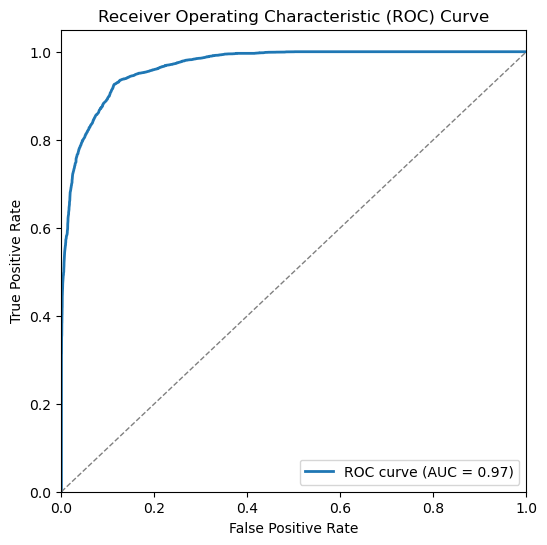

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. Prepare data
# ----------------------------
# Convert labels to integers
star_type_int = star_type.astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    m_r_p, star_type_int, test_size=0.2, random_state=42, stratify=star_type_int
)

# ----------------------------
# 2. Define KNN classifier
# ----------------------------
# Adjust n_neighbors to control accuracy
classifier = KNeighborsClassifier(n_neighbors=1500)

# ----------------------------
# 3. Cross-validation (no scaling)
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "precision": make_scorer(precision_score, average='macro'),
    "recall": make_scorer(recall_score, average='macro'),
    "f1": make_scorer(f1_score, average='macro')
}

scores = cross_validate(classifier, X_train, y_train, cv=cv, scoring=scoring)

# Print cross-validation metrics
print("Cross-validation results (KNN, no scaling):")
for key in ["test_precision", "test_recall", "test_f1"]:
    mean = np.mean(scores[key])
    std = np.std(scores[key])
    print(f"{key}: {mean:.4f} ± {std:.4f}")

# ----------------------------
# 4. Train classifier on full training set
# ----------------------------
classifier.fit(X_train, y_train)

# ----------------------------
# 5. ROC curve plotting (binary)
# ----------------------------
# Predict probabilities for positive class
y_test_proba = classifier.predict_proba(X_test)[:, 1]

# Binarize test labels
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

# Compute ROC
fpr, tpr, _ = roc_curve(y_test_bin, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


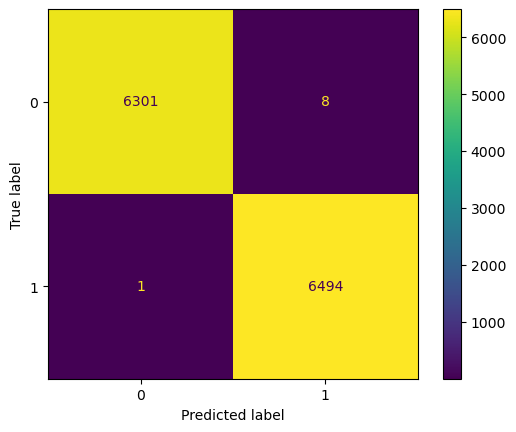

accuracy score:99.93%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6309
           1       1.00      1.00      1.00      6495

    accuracy                           1.00     12804
   macro avg       1.00      1.00      1.00     12804
weighted avg       1.00      1.00      1.00     12804



In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

m_r_prediction = classifier.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
print(f"accuracy score:{accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))


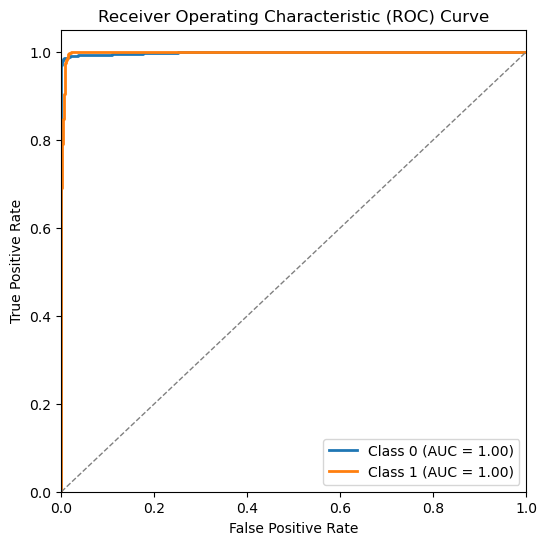

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  roc_curve, auc
import matplotlib.pyplot as plt


# Train RandomForest model
classifier = RandomForestClassifier(n_estimators=500, criterion="entropy", max_depth=12, max_features="log2", random_state=0)
classifier.fit(X_train, y_train)

# Predict probabilities for ROC curve
y_test_proba = classifier.predict_proba(X_test)
# Compute ROC curve and AUC score for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classifier.classes_):
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, i], pos_label=class_label)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Plot ROC Curve
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


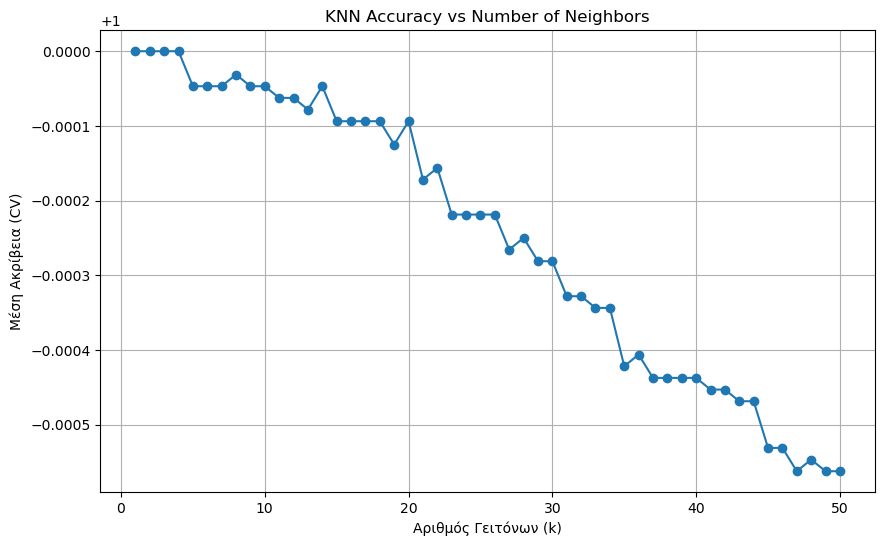

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# 📂 Διάβασε τα δεδομένα
data = pd.read_csv("custom_sample_mass_radius_k2_15.csv", 
                   header=None, 
                   names=["Mass", "Radius", "k2", "Type"], 
                   low_memory=False)

X = data.iloc[1:, :-1]   # features
y = data.iloc[1:, -1]    # target (star type)

# ⚖️ Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Δοκιμή διαφορετικών k
k_values = range(1, 51)   # από 1 έως 50 γείτονες
mean_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring="accuracy")
    mean_accuracies.append(scores.mean())

# 📊 Plot
plt.figure(figsize=(10,6))
plt.plot(k_values, mean_accuracies, marker="o")
plt.xlabel("Αριθμός Γειτόνων (k)")
plt.ylabel("Μέση Ακρίβεια (CV)")
plt.title("KNN Accuracy vs Number of Neighbors")
plt.grid(True)
plt.show()


In [16]:
# Convert features to numeric
X_numeric = m_r_p.astype(float)

# Add Gaussian noise
noise = np.random.normal(0, 0.2, size=X_numeric.shape)
X_noisy = X_numeric + noise

# Convert labels to integers
star_type_int = star_type.astype(int)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_noisy)

# Define KNN classifier
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=200)

# Stratified K-Fold
from sklearn.model_selection import StratifiedKFold, cross_validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
     "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average='macro'),
    "recall": make_scorer(recall_score, average='macro'),
    "f1": make_scorer(f1_score, average='macro')
}

# Run cross-validation
scores = cross_validate(classifier, X_scaled, star_type_int, cv=cv, scoring=scoring)

# Print results
import numpy as np
print("Cross-validation results with lower accuracy:")
for key in ["test_accuracy", "test_precision", "test_recall", "test_f1"]:
    print(f"{key}: {np.mean(scores[key]):.4f} ± {np.std(scores[key]):.4f}")


Cross-validation results with lower accuracy:
test_accuracy: 0.8427 ± 0.0042
test_precision: 0.8447 ± 0.0042
test_recall: 0.8421 ± 0.0042
test_f1: 0.8422 ± 0.0042
